# Fáza 3 - strojové učenie

**Michaela Gubovská, Jakub Hajdu**

V tejto fáze využijeme nami predspracované dáta z predošlej fázy na natrénovanie modelu, ktorý bude schopný robiť rozumné predikcie pre nové pozorovania pomocou strojového učenia.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import category_encoders as ce
from datetime import datetime
from sklearn.impute import SimpleImputer, KNNImputer
from copy import deepcopy
from scipy import mean
from sklearn import tree, metrics, svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression

xtrain = pd.read_csv("data/X_train.csv", sep=',')
xtest = pd.read_csv("data/X_test.csv", sep=',')
ytrain = pd.read_csv("data/y_train.csv", sep=',')
ytest = pd.read_csv("data/y_test.csv", sep=',')


profiles = "data/profiles.csv"
dfp = pd.read_csv(profiles, sep='\t')

labor = "data/labor.csv"
dfl = pd.read_csv(labor, sep='\t')

Načítali sme si trénovacie a testovacie dáta.

In [2]:
xtrain.head()

,hematokrit,hemoglobin,er-cv,erytrocyty,hbver
0,0.489452,0.781517,0.365514,0.493230,0.458152
1,0.632758,0.324983,0.464994,0.562196,0.680407
2,0.509218,0.604928,0.540910,0.470804,0.371400
3,0.613710,0.483566,0.588659,0.497569,0.347080
4,0.456906,0.723530,0.321346,0.477563,0.261482


In [3]:
ytrain.head()

,indicator
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0


Vytvoríme si zlúčený trénovací dataframe pre jednoduhšiu prácu pri OneR klasifikácii.

In [4]:
train_join = xtrain.join(ytrain)
train_join

,hematokrit,hemoglobin,er-cv,erytrocyty,hbver,indicator
0,0.489452,0.781517,0.365514,0.493230,0.458152,1.0
1,0.632758,0.324983,0.464994,0.562196,0.680407,0.0
2,0.509218,0.604928,0.540910,0.470804,0.371400,0.0
3,0.613710,0.483566,0.588659,0.497569,0.347080,0.0
4,0.456906,0.723530,0.321346,0.477563,0.261482,0.0
...,...,...,...,...,...,...
7433,0.599123,0.666367,0.750780,0.116027,0.515945,1.0
7434,0.795075,0.003092,0.494317,0.229950,0.512240,0.0
7435,0.481418,0.620453,0.577534,0.300379,0.594770,1.0
7436,0.344020,0.363165,0.536503,0.393597,0.535648,1.0


Už vo fáze EDA sme videli výraznejšiu závislosť indikátora a hemoglobínu, taktiež indikátora a hematokritu. Tieto dva atribúty po predspracovaní rovnako skončili medzi najdôležitejšími ohľadom vplyvu na indikátor. Úplne manuálne by sa dali pravidlá stanoviť napríklad tak, že sa pozrieme na rozdielne priemery atribútu skupiny s indikátorom 0 v porovnaní s indikátorom 1. 

[Text(0.5, 0, 'indicator'), Text(0, 0.5, 'hemoglobin')]

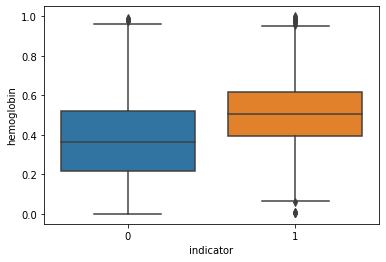

In [5]:
xtrain0 = train_join[train_join['indicator']==0]
xtrain1 = train_join[train_join['indicator']==1]
sns.boxplot(data=[xtrain0['hemoglobin'], xtrain1['hemoglobin']]).set(xlabel='indicator', ylabel='hemoglobin')

Napríklad pri hemoglobíne by sme mohli povedať, že by rozhodla hodnota v strede medzi priemermi skupín s indikátorom 0 a 1.
Menšie hodnoty ako táto hranica by klasifikovali indikátor 0, naopak vyššie by znamenali indikátor 1. Táto hodnota je:

In [6]:
manual_value = np.mean([xtrain0['hemoglobin'].mean(), xtrain1['hemoglobin'].mean()])
manual_value

0.44151760432413656

Spočítame si úspešnosť na trénovacom sete.

In [7]:
correct = 0
for i in range(len(train_join)):
    value = train_join.iloc[i]['hemoglobin']
    if train_join.iloc[i]['hemoglobin'] < manual_value:
        if ytrain.iloc[i]['indicator']==0:
            correct += 1
    else:
        if ytrain.iloc[i]['indicator']==1:
            correct += 1
correct/len(train_join)

0.6411669803710675

Vidíme, že úspešnosť takto zvoleného pravidla sa blíži k dvom tretinám. Dá sa však zlepšiť.

Vytvoríme si dataframe, do ktorého si budeme ukladať informácie o klasifikačných algoritmoch pre účel ich porovnania.

In [8]:
algorithm_accuracy = pd.DataFrame(columns=['algorithm', 'hyperparameters', 'accuracy', 'precision', 'recall'])

## 1. Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu

Definujeme si funkciu, ktorá vytvorí pravidlá pre OneR algoritmus.

- na vstupe očakáva dataframe s atribútmi a indikátorom, stĺpce, pre ktoré chceme vytvárať pravidlá a počet skupín
- podľa buckets sa dataframe rozdelí na skupiny, ktoré slúžia na diskretizáciu hodnôt
- body na hranici týchto buckets sú potenciálne body binárneho delenia na indikátor 0 a 1
- každý z týchto bodov sa skúma na úspešnosť klasifikácie záznamov menších a väčších ako daná hodnota
- najlepší bod rozdelenia so svojou úspešnosťou je vybratý ako pravidlo
- pravidlá sa ukladajú do svojho dataframe a nakoniec sú zoradené od najúspešnejšieho

In [9]:
def one_r_make_rules(data, cols, buckets):
    
    rules = pd.DataFrame(columns=['attribute', 'value', 'smaller', 'importance'])
    
    for attribute in cols:
        scores = pd.DataFrame(columns=['value', 'smaller', 'success'])
        data_sort = data[[attribute, 'indicator']].sort_values(by=attribute)
        
        for i, point in enumerate(np.arange(len(data_sort)//buckets, len(data_sort), len(data_sort)//buckets)):
            data_left = data_sort[:point]
            data_right = data_sort[point:]
            success = (len(data_left[data_left['indicator']==0]) + len(data_right[data_right['indicator']==1])) / len(data_sort)
            if success < 0.5:
                scores = scores.append({'value':data_sort.iloc[point][attribute], 'smaller':1, 'success':1-success}, ignore_index=True)
            else:
                scores = scores.append({'value':data_sort.iloc[point][attribute], 'smaller':0, 'success':success}, ignore_index=True)
        #print(scores)
        best = scores.sort_values(by='success', ascending=False).reset_index().loc[0]
        rules = rules.append({'attribute':attribute, 'value':best['value'], 'smaller':best['smaller'], 'importance':best['success']}, ignore_index=True)
    
    rules = rules.sort_values(by='importance', ascending=False).reset_index()
    return rules

Funkcia na čitateľný výpis vytvorených pravidiel

- best = True vypíše len najlepšie pravidlo, False vypíše všetky

In [10]:
def one_r_print_rules(rules, best):
    if best:
        print('If', rules.iloc[0]['attribute'], 'is smaller than', rules.iloc[0]['value'], ': indicator =', int(rules.iloc[0]['smaller']), 'importance:', rules.iloc[0]['importance'], '\n')
    else:
        for i in range(len(rules)):
            print('If', rules.iloc[i]['attribute'], 'is smaller than', rules.iloc[i]['value'], ': indicator =', int(rules.iloc[i]['smaller']), 'importance:', rules.iloc[i]['importance'], '\n')

Ďalej si definujeme funkciu, ktorá vykoná samotnú klasifikáciu, vracia dataframe s klasifikovanými hodnotami indikátora

In [11]:
def one_r_classify(data, rule):
    lo = rule['smaller']
    hi = 1.0 if lo == 0 else 0.0
    
    result = pd.DataFrame(columns=['indicator'])
    
    for i in range(len(data)):
        value = data.iloc[i][rule['attribute']]
        if value < rule['value']:
            result = result.append({'indicator':lo}, ignore_index=True)
        else:
            result = result.append({'indicator':hi}, ignore_index=True)
    return result

In [12]:
def count_positives_negatives(classified, train):
    tp = tn = fp = fn = 0
    for i in range(len(train)):
        a = train.iloc[i]['indicator']
        b = classified.iloc[i]['indicator']
        if a == b:
            if a == 0:
                tn += 1
            else:
                tp += 1
            
        else:
            if a == 0:
                fp += 1
            else:
                fn += 1
            
    return tp, tn, fp, fn

In [13]:
rules = one_r_make_rules(train_join, xtrain.columns, 50)
one_r_print_rules(rules, False)

If hemoglobin is smaller than 0.2838841865790894 : indicator = 0 importance: 0.7225060500134445 

If hematokrit is smaller than 0.5895401015348607 : indicator = 1 importance: 0.6628125840279645 

If erytrocyty is smaller than 0.8498849070929964 : indicator = 1 importance: 0.6472169938155419 

If hbver is smaller than 0.8278276577878817 : indicator = 1 importance: 0.64425920946491 

If er-cv is smaller than 0.9406695269801008 : indicator = 1 importance: 0.6437214304920678 



Po skúšaní rôzneho počtu bucketov sme prišli na to, že 50 poskytuje dostatočne detailné "rozlíšenie" hraničnej hodnoty, možno by stačilo aj 10 alebo 15. Naopak 500 bucketov nemalo prakticky takmer žiadny efekt na úspešnosť pravidla (nárast o 0,1%).

Môžeme sa pozrieť na úspešnosť takéhoto klasifikátora na testovacom sete. Vidíme, že má veľmi podobnú úspešnosť:

In [14]:
ytest_classified = one_r_classify(xtest, rules.loc[0])
tp, tn, fp, fn = count_positives_negatives(ytest_classified, ytest)

In [15]:
print(f'No. of true positives: {tp}\nNo. of true negatives: {tn}\nNo. of false positives: {fp}\nNo. of false negatives: {fn}')

No. of true positives: 1486
No. of true negatives: 279
No. of false positives: 608
No. of false negatives: 107


**Vyhodnotenie pomocou metriky accuracy** (počet true positive + počet true negative / počet všetkých)

In [16]:
acc = metrics.accuracy_score(ytest, ytest_classified)
print('Accuracy :', acc * 100, '%')

Accuracy : 71.16935483870968 %


**Vyhodnotenie pomocou metriky precision** (počet true positive / (počet true positives + počet false positives))

In [17]:
prec = metrics.precision_score(ytest, ytest_classified)
print('Precision :', prec * 100, '%')

Precision : 70.96466093600765 %


**Vyhodnotenie pomocou metriky recall** (počet true positives / (počet true positives + počet false negatives))

In [18]:
rec = metrics.recall_score(ytest, ytest_classified)
print('Recall :', rec * 100, '%')

Recall : 93.28311362209666 %


In [19]:
algorithm_accuracy = algorithm_accuracy.append({'algorithm':'oneR', 'accuracy':acc, 'precision':prec, 'recall':rec}, ignore_index=True)

Na základe vyhodnotení môžeme povedať, že nami vytvorený klasifikátor dosahuje dobrú úspešnosť.

## 2. Natrénovanie a vyhodnotenie klasifikátora strojového učenia

V tejto časti sme zvolili použiť Decision Tree klasifikátor z knižnice sklearn.

Najskôr si natrénujeme klasifikátor na naše trénovacie dáta.

[Text(196.88033253027635, 425.82, 'X[1] <= 0.287\ngini = 0.458\nsamples = 7438\nvalue = [2636, 4802]'),
 Text(46.64466680332205, 407.7, 'X[0] <= 0.439\ngini = 0.409\nsamples = 1370\nvalue = [978, 392]'),
 Text(16.264176893779094, 389.58, 'X[3] <= 0.391\ngini = 0.168\nsamples = 194\nvalue = [18, 176]'),
 Text(11.747989843419383, 371.46, 'X[0] <= 0.417\ngini = 0.122\nsamples = 184\nvalue = [12, 172]'),
 Text(5.549301735082523, 353.34, 'X[4] <= 0.309\ngini = 0.071\nsamples = 162\nvalue = [6, 156]'),
 Text(1.8891239949217098, 335.21999999999997, 'X[0] <= 0.286\ngini = 0.48\nsamples = 5\nvalue = [2, 3]'),
 Text(0.9445619974608549, 317.1, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(2.8336859923825646, 317.1, 'X[1] <= 0.242\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(1.8891239949217098, 298.98, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(3.7782479898434196, 298.98, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(9.209479475243334, 335.21999999999997, 'X[2] <= 0.035\ngini

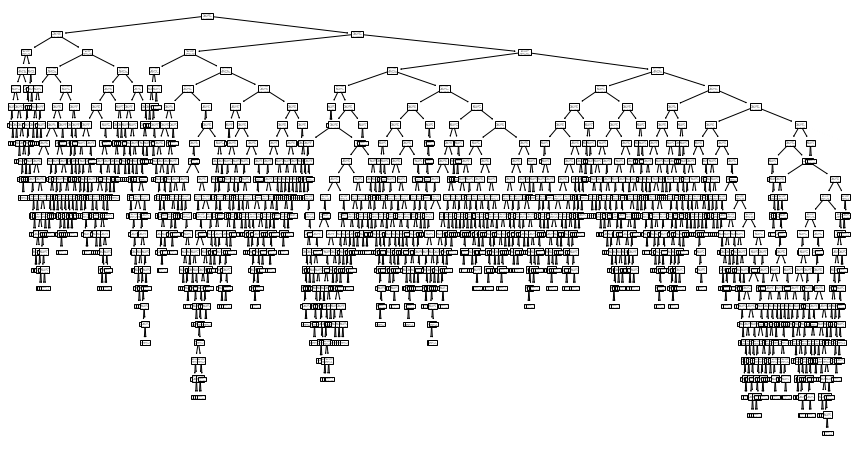

In [20]:
clf0 = tree.DecisionTreeClassifier()
clf0 = clf0.fit(xtrain, ytrain)
plt.figure(figsize=(15,8))
tree.plot_tree(clf0) 

Natrénovaný klasifikátor spraví predikciu na našu testovaciu množinu dát a následne sa pozrieme akú úspešnosť pri klasifikácii dát dosiahol.

In [21]:
ypred0 = clf0.predict(xtest)

In [22]:
acc = metrics.accuracy_score(ytest, ypred0)
print("Accuracy :", acc * 100, '%')

Accuracy : 78.54838709677419 %


In [23]:
prec = metrics.precision_score(ytest, ypred0)
print("Precision :", prec * 100, '%')

Precision : 82.8890266584005 %


In [24]:
rec = metrics.recall_score(ytest, ypred0)
print("Recall :", rec * 100, '%')

Recall : 83.92969240426868 %


Podľa výsledkov vidíme, že takýto klasifikátor bez použitia hyperparamtrov dosiahol dobrú úspešnosť.

Oproti nami vytvorenému One-R klasifikátoru dosiahol tento rozhodovací strom vyššiu accuracy aj precision, avšak recall dosiahol menší.

In [25]:
algorithm_accuracy = algorithm_accuracy.append({'algorithm':'basic decision tree', 'accuracy':acc, 'precision':prec, 'recall':rec}, ignore_index=True)

## 3. Optimalizácia - hyperparameter tuning

Pre dosianutie lepších výsledkov, teda vyššej presnosti klasifikácie dát sa v tejto časti pozrieme na niekoľko možných hyperparametrov pre nami zvolený algoritmus rozhodovacieho stromu. Najlepšiu kombináciu hyperparametrov nájdeme pomocou grid search algoritmu a úspešnosť vyhodnotíme pomocou 5 násobnej cross-validation.

### Decision tree - manuálne skúšanie rôznych hyperparametrov

Nastavenia hodnoty hyperparametrov sú nami nájdené hodnoty, ktoré pri skúšaní rôznych hodnôt vyšli najúspešnejšie.

Vytvoríme si dataframe do ktorého si budeme ukladať kombinácie hyperparametrov decision trees s ich úspešnosťou.

In [26]:
hyperparameters = pd.DataFrame(columns=['hyperparameters', 'accuracy'])

**max_depth**

Nastavením tohto hyperparametra sa zastaví ďalšie delenie stromu po dosiahnutí hĺbky zadanej v hodnote tohto parametra.

[Text(308.3250393907563, 410.71999999999997, 'X[1] <= 0.287\ngini = 0.458\nsamples = 7438\nvalue = [2636, 4802]'),
 Text(119.79122899159664, 362.4, 'X[0] <= 0.439\ngini = 0.409\nsamples = 1370\nvalue = [978, 392]'),
 Text(55.16990546218487, 314.08, 'X[3] <= 0.391\ngini = 0.168\nsamples = 194\nvalue = [18, 176]'),
 Text(40.00367647058823, 265.76, 'X[0] <= 0.417\ngini = 0.122\nsamples = 184\nvalue = [12, 172]'),
 Text(20.221638655462186, 217.44, 'X[4] <= 0.309\ngini = 0.071\nsamples = 162\nvalue = [6, 156]'),
 Text(7.033613445378151, 169.12, 'X[0] <= 0.286\ngini = 0.48\nsamples = 5\nvalue = [2, 3]'),
 Text(3.5168067226890756, 120.80000000000001, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(10.550420168067227, 120.80000000000001, 'X[1] <= 0.242\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(7.033613445378151, 72.48000000000002, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(14.067226890756302, 72.48000000000002, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(33.40966386554

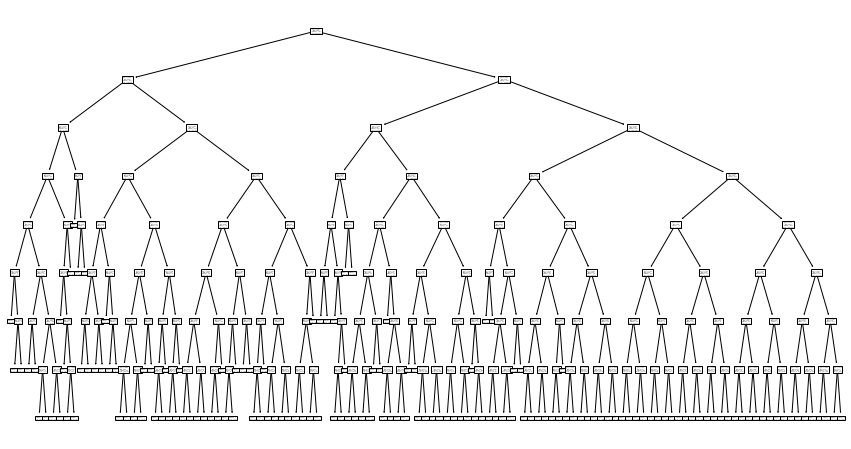

In [27]:
clf1 = tree.DecisionTreeClassifier(max_depth=8)
clf1 = clf1.fit(xtrain, ytrain)
plt.figure(figsize=(15,8))
tree.plot_tree(clf1)

In [28]:
ypred1 = clf1.predict(xtest)

In [29]:
scores1 = cross_val_score(clf1, xtrain, ytrain, cv=5)
scores1

array([0.83803763, 0.82526882, 0.83602151, 0.8399462 , 0.82851379])

In [30]:
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores1.mean(), scores1.std()))

0.8336 accuracy with a standard deviation of 0.0057


In [31]:
hyperparameters = hyperparameters.append({'hyperparameters':'max_depth', 'accuracy': scores1.mean()}, ignore_index=True)

**gini**

Nastavením kritéria na hyperparameter gini sa do rozhodovania vkladá "impurity", t.j. náhodne sa označí vybratý element stromu nesprávnym označením a toto označenie bolo tiež náhodné.

[Text(196.09724244043514, 425.82, 'X[1] <= 0.287\ngini = 0.458\nsamples = 7438\nvalue = [2636, 4802]'),
 Text(46.93356006228484, 407.7, 'X[0] <= 0.439\ngini = 0.409\nsamples = 1370\nvalue = [978, 392]'),
 Text(16.367498314227916, 389.58, 'X[3] <= 0.391\ngini = 0.168\nsamples = 194\nvalue = [18, 176]'),
 Text(11.822621286865173, 371.46, 'X[0] <= 0.417\ngini = 0.122\nsamples = 184\nvalue = [12, 172]'),
 Text(5.584554778720233, 353.34, 'X[4] <= 0.309\ngini = 0.071\nsamples = 162\nvalue = [6, 156]'),
 Text(1.9011250310536962, 335.21999999999997, 'X[0] <= 0.286\ngini = 0.48\nsamples = 5\nvalue = [2, 3]'),
 Text(0.9505625155268481, 317.1, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(2.8516875465805445, 317.1, 'X[1] <= 0.242\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(1.9011250310536962, 298.98, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(3.8022500621073925, 298.98, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(9.267984526386769, 335.21999999999997, 'X[2] <= 0.035\ngini

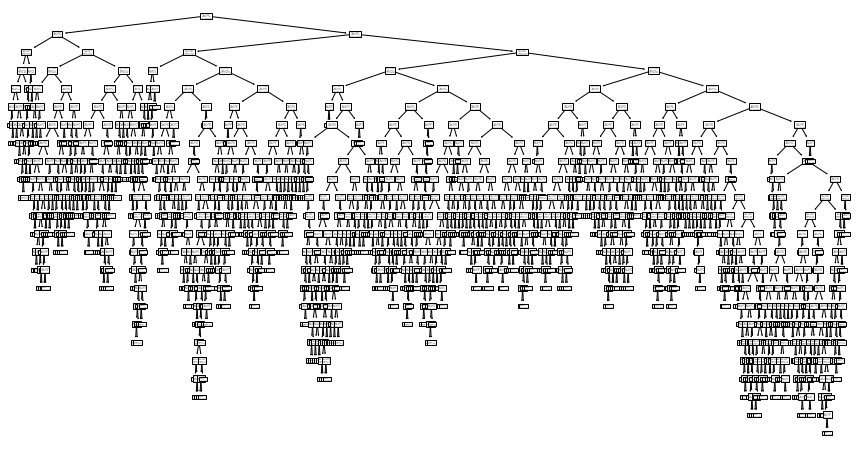

In [32]:
clf2 = tree.DecisionTreeClassifier(criterion='gini')
clf2 = clf2.fit(xtrain, ytrain)
plt.figure(figsize=(15,8))
tree.plot_tree(clf2)

In [33]:
ypred2 = clf2.predict(xtest)

In [34]:
scores2 = cross_val_score(clf2, xtrain, ytrain, cv=5)
scores2

array([0.8077957 , 0.8125    , 0.80241935, 0.81573638, 0.7995965 ])

In [35]:
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores2.mean(), scores2.std()))

0.8076 accuracy with a standard deviation of 0.0060


In [36]:
hyperparameters = hyperparameters.append({'hyperparameters':'gini', 'accuracy': scores2.mean()}, ignore_index=True)

**max_depth + gini**

Kombinácia hyperparametrov, kedy sa genrovanie rozhodovacieho stromu ukončí po dosiahnutí hodnoty v max_depth a zároveň je v algoritme prítomná "impurity", ktorá náhodne označuje náhodné elementy stromu a toto označenie je nespávne.

[Text(308.12938023012555, 410.71999999999997, 'X[1] <= 0.287\ngini = 0.458\nsamples = 7438\nvalue = [2636, 4802]'),
 Text(117.9767259414226, 362.4, 'X[0] <= 0.439\ngini = 0.409\nsamples = 1370\nvalue = [978, 392]'),
 Text(52.3125, 314.08, 'X[3] <= 0.391\ngini = 0.168\nsamples = 194\nvalue = [18, 176]'),
 Text(38.08525104602511, 265.76, 'X[0] <= 0.417\ngini = 0.122\nsamples = 184\nvalue = [12, 172]'),
 Text(20.13702928870293, 217.44, 'X[4] <= 0.309\ngini = 0.071\nsamples = 162\nvalue = [6, 156]'),
 Text(10.506276150627615, 169.12, 'X[1] <= 0.242\ngini = 0.48\nsamples = 5\nvalue = [2, 3]'),
 Text(7.00418410041841, 120.80000000000001, 'X[0] <= 0.259\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(3.502092050209205, 72.48000000000002, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(10.506276150627615, 72.48000000000002, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(14.00836820083682, 120.80000000000001, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(29.767782426778243, 169.12,

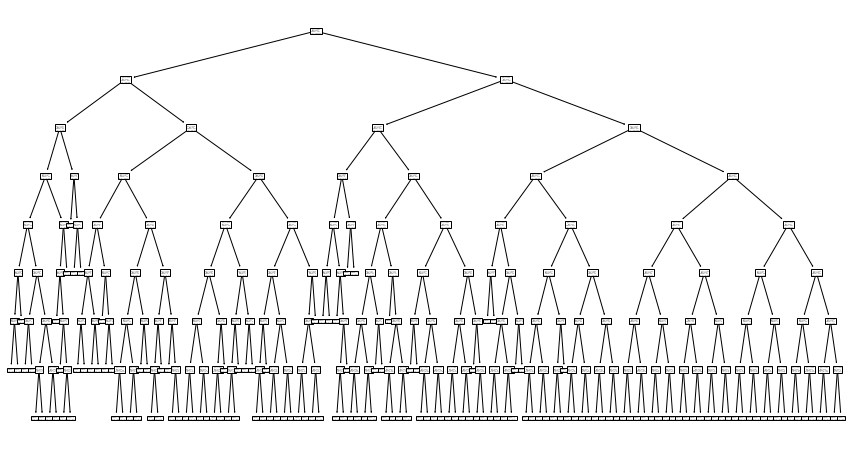

In [37]:
clf3 = tree.DecisionTreeClassifier(criterion='gini', max_depth=8)
clf3 = clf3.fit(xtrain, ytrain)
plt.figure(figsize=(15,8))
tree.plot_tree(clf3)

In [38]:
ypred3 = clf3.predict(xtest)

In [39]:
scores3 = cross_val_score(clf3, xtrain, ytrain, cv=5)
scores3

array([0.83870968, 0.82728495, 0.83400538, 0.84263618, 0.8271688 ])

In [40]:
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores3.mean(), scores3.std()))

0.8340 accuracy with a standard deviation of 0.0061


In [41]:
hyperparameters = hyperparameters.append({'hyperparameters':'max_depth + gini', 'accuracy': scores3.mean()}, ignore_index=True)

**entropy**

Hyperparameter kritérium entropy kontroluje "impurity" elementov rozhodovacieho stromu. Element stromu rozdeľude ďalej až do bodu, kým sa v elemente nenachádza žiadna "impurity", potom sa stane z takéhoto elementu list stromu.

[Text(237.38458739243276, 426.1824, 'X[0] <= 0.422\nentropy = 0.938\nsamples = 7438\nvalue = [2636, 4802]'),
 Text(79.97521196295669, 408.7872, 'X[4] <= 0.343\nentropy = 0.513\nsamples = 2370\nvalue = [271, 2099]'),
 Text(37.765519282814616, 391.392, 'X[0] <= 0.404\nentropy = 0.301\nsamples = 1122\nvalue = [60, 1062]'),
 Text(25.129820703653586, 373.9968, 'X[3] <= 0.617\nentropy = 0.259\nsamples = 1028\nvalue = [45, 983]'),
 Text(14.582374830852503, 356.6016, 'X[1] <= 0.713\nentropy = 0.322\nsamples = 596\nvalue = [35, 561]'),
 Text(7.645128552097429, 339.20640000000003, 'X[3] <= 0.196\nentropy = 0.266\nsamples = 575\nvalue = [26, 549]'),
 Text(3.397834912043302, 321.8112, 'X[3] <= 0.181\nentropy = 0.881\nsamples = 10\nvalue = [3, 7]'),
 Text(2.2652232746955345, 304.416, 'X[1] <= 0.22\nentropy = 0.544\nsamples = 8\nvalue = [1, 7]'),
 Text(1.1326116373477673, 287.0208, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(3.397834912043302, 287.0208, 'entropy = 0.0\nsamples = 7\nvalue = 

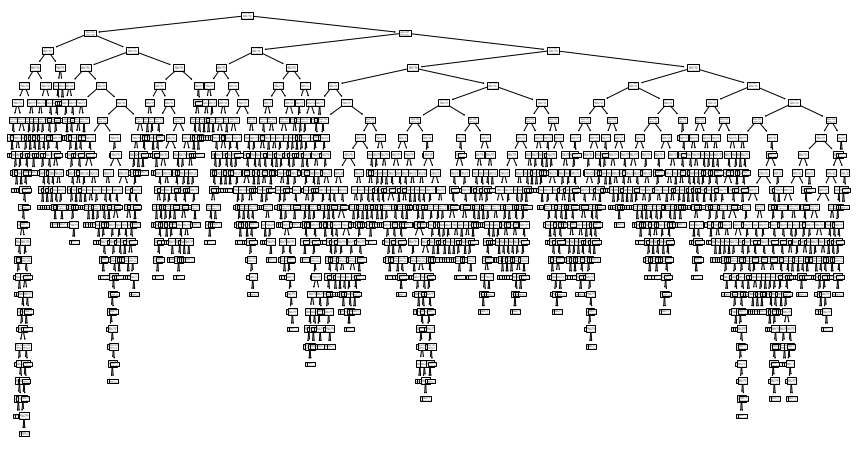

In [42]:
clf4 = tree.DecisionTreeClassifier(criterion='entropy')
clf4 = clf4.fit(xtrain, ytrain)
plt.figure(figsize=(15,8))
tree.plot_tree(clf4)

In [43]:
ypred4 = clf4.predict(xtest)

In [44]:
scores4 = cross_val_score(clf4, xtrain, ytrain, cv=5)
scores4

array([0.81586022, 0.80376344, 0.81182796, 0.82582381, 0.81708137])

In [45]:
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores4.mean(), scores4.std()))

0.8149 accuracy with a standard deviation of 0.0072


In [46]:
hyperparameters = hyperparameters.append({'hyperparameters':'entropy', 'accuracy': scores4.mean()}, ignore_index=True)

**max_depth + entropy**

Kombinácia hyperparametrov, kedy sa generovanie rozhodovacieho stromu ukončí po dosiahnutí hodnoty v max_depth a zároveň sa generujú nové elementý až pokiaľ nedosiahnu žiadnu "impurity" a stanú sa listami stromu.

[Text(345.7193386130137, 410.71999999999997, 'X[0] <= 0.422\nentropy = 0.938\nsamples = 7438\nvalue = [2636, 4802]'),
 Text(152.18996147260273, 362.4, 'X[4] <= 0.343\nentropy = 0.513\nsamples = 2370\nvalue = [271, 2099]'),
 Text(87.60552226027397, 314.08, 'X[0] <= 0.404\nentropy = 0.301\nsamples = 1122\nvalue = [60, 1062]'),
 Text(57.68707191780822, 265.76, 'X[3] <= 0.617\nentropy = 0.259\nsamples = 1028\nvalue = [45, 983]'),
 Text(30.81421232876712, 217.44, 'X[1] <= 0.713\nentropy = 0.322\nsamples = 596\nvalue = [35, 561]'),
 Text(15.76541095890411, 169.12, 'X[3] <= 0.196\nentropy = 0.266\nsamples = 575\nvalue = [26, 549]'),
 Text(8.59931506849315, 120.80000000000001, 'X[3] <= 0.181\nentropy = 0.881\nsamples = 10\nvalue = [3, 7]'),
 Text(5.732876712328767, 72.48000000000002, 'X[1] <= 0.22\nentropy = 0.544\nsamples = 8\nvalue = [1, 7]'),
 Text(2.8664383561643834, 24.159999999999968, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(8.59931506849315, 24.159999999999968, 'entropy = 0.

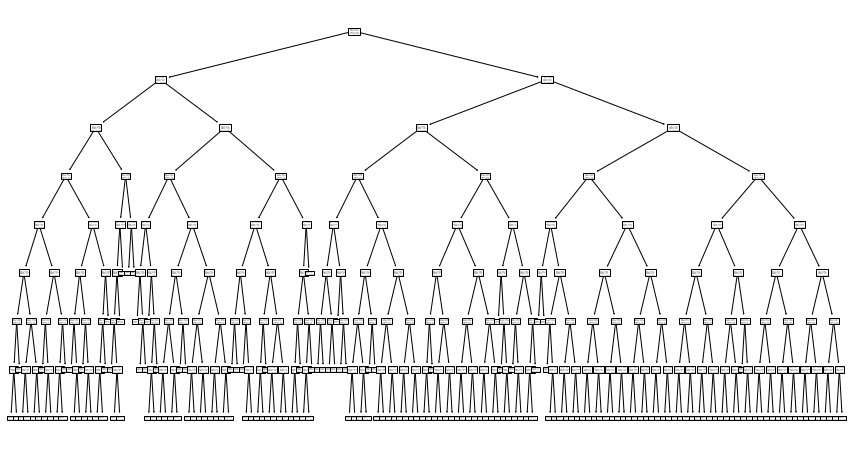

In [47]:
clf5 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=8)
clf5 = clf5.fit(xtrain, ytrain)
plt.figure(figsize=(15,8))
tree.plot_tree(clf5)

In [48]:
ypred5 = clf5.predict(xtest)

In [49]:
scores5 = cross_val_score(clf5, xtrain, ytrain, cv=5)
scores5

array([0.83803763, 0.83736559, 0.84341398, 0.85541358, 0.82918628])

In [50]:
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores5.mean(), scores5.std()))

0.8407 accuracy with a standard deviation of 0.0087


In [51]:
hyperparameters = hyperparameters.append({'hyperparameters':'max_depth + entropy', 'accuracy': scores5.mean()}, ignore_index=True)

**max_leaf_nodes**

Nastavením tohto hyperparametra sa zastaví ďalšie delenie stromu po dosiahnutí počtu listov zadaného v hodnote parametra. Strom sa generuje best-first algoritmom a za najlepšie elementy sa považujú tie s najnižšou "impurity".

[Text(202.99109842051632, 424.5257142857143, 'X[1] <= 0.287\ngini = 0.458\nsamples = 7438\nvalue = [2636, 4802]'),
 Text(51.21317934782609, 403.81714285714287, 'X[0] <= 0.439\ngini = 0.409\nsamples = 1370\nvalue = [978, 392]'),
 Text(12.130434782608697, 383.1085714285714, 'X[3] <= 0.391\ngini = 0.168\nsamples = 194\nvalue = [18, 176]'),
 Text(4.852173913043479, 362.4, 'X[0] <= 0.417\ngini = 0.122\nsamples = 184\nvalue = [12, 172]'),
 Text(2.4260869565217393, 341.69142857142856, 'gini = 0.071\nsamples = 162\nvalue = [6, 156]'),
 Text(7.278260869565218, 341.69142857142856, 'X[4] <= 0.475\ngini = 0.397\nsamples = 22\nvalue = [6, 16]'),
 Text(4.852173913043479, 320.98285714285714, 'X[4] <= 0.344\ngini = 0.48\nsamples = 15\nvalue = [6, 9]'),
 Text(2.4260869565217393, 300.2742857142857, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(7.278260869565218, 300.2742857142857, 'X[3] <= 0.112\ngini = 0.496\nsamples = 11\nvalue = [6, 5]'),
 Text(4.852173913043479, 279.5657142857143, 'gini = 0.0\ns

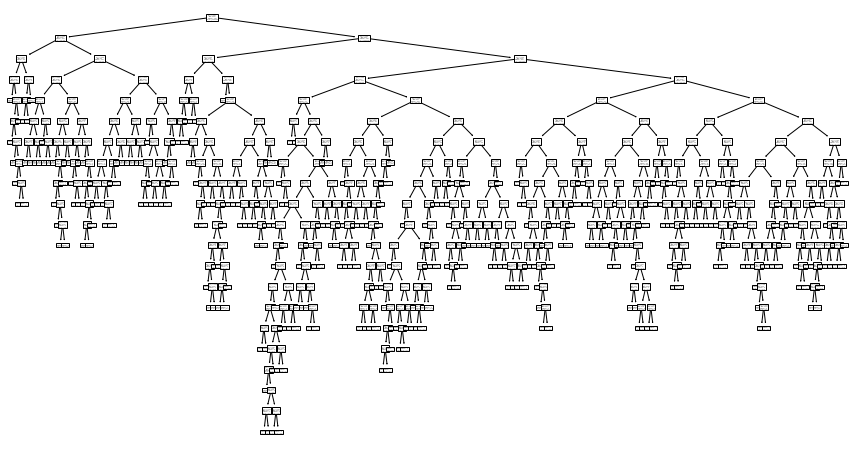

In [52]:
clf6 = tree.DecisionTreeClassifier(max_leaf_nodes=340)
clf6 = clf6.fit(xtrain, ytrain)
plt.figure(figsize=(15,8))
tree.plot_tree(clf6)

In [53]:
ypred6 = clf6.predict(xtest)

In [54]:
scores6 = cross_val_score(clf6, xtrain, ytrain, cv=5)
scores6

array([0.83736559, 0.83266129, 0.83198925, 0.83927371, 0.83254876])

In [55]:
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores6.mean(), scores6.std()))

0.8348 accuracy with a standard deviation of 0.0030


In [56]:
hyperparameters = hyperparameters.append({'hyperparameters':'max_leaf_nodes', 'accuracy': scores6.mean()}, ignore_index=True)

Finálna úspešnosť všetkých nami zvolených kombinácií hyperparametrov vyzerá nasledovne:

In [57]:
hyperparameters

,hyperparameters,accuracy
0,max_depth,0.833558
1,gini,0.807610
2,max_depth + gini,0.833961
3,entropy,0.814871
4,max_depth + entropy,0.840683
5,max_leaf_nodes,0.834768


Najúspešnejší rozhodovací strom mal kombináciu hyperparametrov *max_depth* a *entropy*, dosiahol accuracy 84.15%:

In [58]:
hyperparameters[hyperparameters['accuracy']==hyperparameters['accuracy'].max()]

,hyperparameters,accuracy
4,max_depth + entropy,0.840683


Porovnanie nami navrhnutých hyperparametrov a úspešnosť rozhodovacích stromov s danými hyperparametrami:

<AxesSubplot:xlabel='hyperparameters', ylabel='accuracy'>

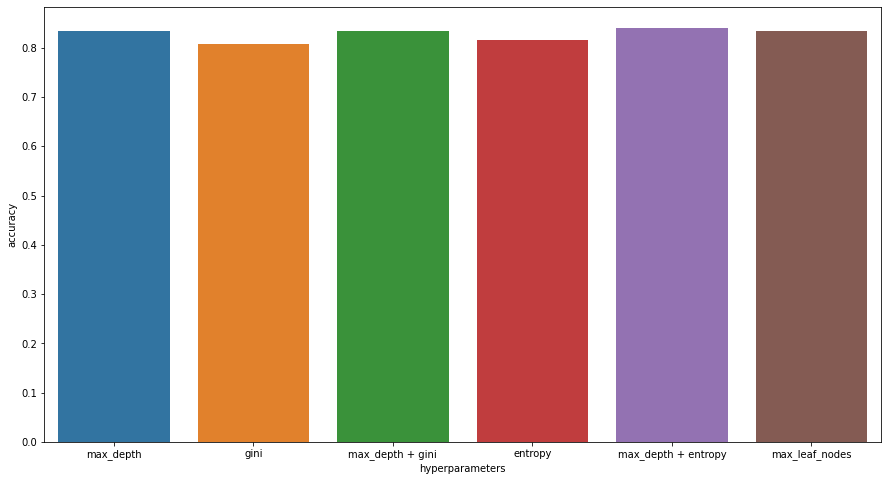

In [59]:
plt.figure(figsize=(15,8))
sns.barplot(data=hyperparameters, x=hyperparameters.hyperparameters, y=hyperparameters.accuracy)

### Gridsearch

Pre optimálne zvolenie hyperparametrov klasifikačných algoritmov je vhodné použiť grid search. Ten prejde všetky kombinácie nami zadaných parametrov, pre kazdú kombináciu zistí accuracy a vráti nám najlepšiu kombináciu pre klasifikáciu dát s použitím daného algoritmu. Na grid search používame funckiu GridSearchCV() z knižnice sklearn, ktorej sme pridali parameter *cv* na využitie 5-násobnej cross-validation na nájdenie najlepšieho skóre danej kombinácie hyperparametrov.

Pomocou grid search sme optimalizovali parametre pre 2 klasifikačné algoritmy: **C-Support Vector klasifikátor** a **decision tree klasifikátor**

**SVC a grid search**

Pre SVC algoritmus hľadáme najlepšiu kombináciu hyperparametrov kernel (linear alebo rbf) a C (1 alebo 10).

In [60]:
estimator = svm.SVC()
parameters = {'kernel':('linear', 'rbf'), 
              'C':[1, 10]}
scoring = ['accuracy', 
           'precision_micro']

clf = GridSearchCV(estimator=estimator, 
                   param_grid=parameters,
                   cv=5,
                   scoring=scoring,
                   refit='accuracy')
grid1 = clf.fit(xtrain.values, ytrain.values.flatten())

print(grid1.best_estimator_)
print(grid1.best_score_)
print(grid1.best_params_)

SVC(C=10)
0.8763116363320824
{'C': 10, 'kernel': 'rbf'}


Natrénovaný model SVC klasifikátora s najlepšími hyperparametrami spustíme na testovacej množine dát a zistíme jeho accuracy, precision a recall.

In [61]:
ypred7 = grid1.best_estimator_.predict(xtest)

In [62]:
acc = metrics.accuracy_score(ytest, ypred7)
print("Accuracy :", acc * 100, '%')

Accuracy : 86.69354838709677 %


In [63]:
prec = metrics.precision_score(ytest, ypred7)
print("Precision :", prec * 100, '%')

Precision : 86.3139735480161 %


In [64]:
rec = metrics.recall_score(ytest, ypred7)
print("Recall :", rec * 100, '%')

Recall : 94.22473320778406 %


In [65]:
s = ""
for key,value in grid1.best_params_.items():
     s += f"{key}:{value},"
s = s[:len(s)-1]

In [66]:
algorithm_accuracy = algorithm_accuracy.append({'algorithm':'svc grid search', 'hyperparameters':s, 'accuracy':acc, 'precision':prec, 'recall':rec}, ignore_index=True)

**Decision tree grid search**

V prvje časti tejto podkapitoly sme námatkovo skúšali rôzne kombinácie hyperparametrov pre rozhodovací strom. Aby sme však našli tú najúspešnejšiu kombináciu, teraz použijeme grid search na prehľadanie všetkých nami zvolených kombinácií hyperparametrov.

Hodnoty pre konkrétne hyperparametre sme zvolili na základe predošlého skúšania rôznych hodnôt. Kvôli nedostačujúcej výpočtovej technike našich strojov nebolo možné vyskúšať viaceré kombinácie s väčším rozsahom hodnôt. Pozrieme sa teda na kombinácie hyperparametrov:
- *criterion* - hodnota "entropy" alebo "gini", čo robia je vysvetlené v predošlej sekcii
- *max_depth* - čo robí je vysvetlené v predošlej sekcii
- *max_leaf_nodes* - čo robí je vysvetlené v predošlej sekcii
- *min_samples_split* - element stromu musí mať minimálne toľko samples ako je hodnota tohto parametra na to, aby mohol byť rozdelený na 2 child elementy
- *min_samples_leaf* - rozhodovací strom musí mať v liste aspoň toľko samples, ako je hodnota tohto parametra

In [67]:
decision_tree = tree.DecisionTreeClassifier()
params = {
    "criterion":['entropy', 'gini'],
    "max_depth":[5,8,11,14],
    "max_leaf_nodes": [337,340,343,346],
    "min_samples_split":[5,8,11,14],
    "min_samples_leaf":[5,8,11,14]
}
grid2 = GridSearchCV(decision_tree, param_grid=params, cv=5, verbose=1)
grid2.fit(xtrain, ytrain)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [5, 8, 11, 14],
                         'max_leaf_nodes': [337, 340, 343, 346],
                         'min_samples_leaf': [5, 8, 11, 14],
                         'min_samples_split': [5, 8, 11, 14]},
             verbose=1)

Najlepšia kombinácia hyperparametrov a ich hodnoty:

In [68]:
grid2.best_params_

{'criterion': 'entropy',
 'max_depth': 11,
 'max_leaf_nodes': 337,
 'min_samples_leaf': 14,
 'min_samples_split': 8}

In [69]:
grid2.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=11, max_leaf_nodes=337,
                       min_samples_leaf=14, min_samples_split=8)

Úspešnosť modelu rozhodovacieho stromu s najlepšou kombináciou hyperparametrov podľa grid search:

In [70]:
grid2.best_score_

0.8463300214764518

Natrénovaný model rozhodovacieho stromu s najlepšími hyperparametrami spustíme na testovacej množine dát a zistíme jeho accuracy, precision a recall.

In [71]:
ypred8 = grid2.best_estimator_.predict(xtest)

In [72]:
acc = metrics.accuracy_score(ytest, ypred8)
print("Accuracy :", acc * 100, '%')

Accuracy : 83.75 %


In [73]:
prec = metrics.precision_score(ytest, ypred8)
print("Precision :", prec * 100, '%')

Precision : 84.5528455284553 %


In [74]:
rec = metrics.recall_score(ytest, ypred8)
print("Recall :", rec * 100, '%')

Recall : 91.39987445072191 %


In [75]:
s = ""
for key,value in grid2.best_params_.items():
     s += f"{key}:{value},"
s = s[:len(s)-1]

In [76]:
algorithm_accuracy = algorithm_accuracy.append({'algorithm':'decision tree grid search', 'hyperparameters':s, 'accuracy':acc, 'precision':prec, 'recall':rec}, ignore_index=True)

### Porovnanie úspešností nami vyskúšaných algoritmov

Budeme porovnávať accuracy, recall a precision algoritmov:
- **nami vytvorený oneR algoritmus**
- **decision tree bez hyperparametrov**
- **SVC s hyperparametrami optimalizovanými cez grid search**
- **decision tree s hyperparametrami optimalizovanými cez grid search**

<AxesSubplot:xlabel='algorithm', ylabel='accuracy'>

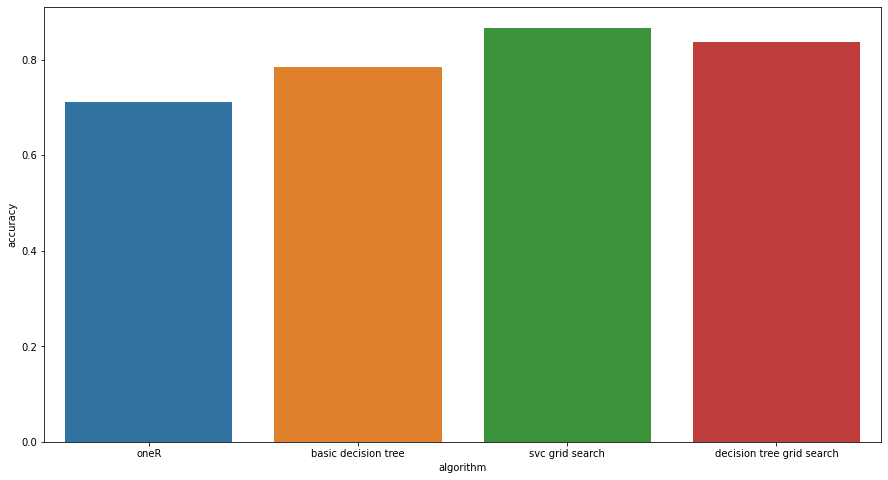

In [77]:
plt.figure(figsize=(15,8))
sns.barplot(data=algorithm_accuracy, x=algorithm_accuracy.algorithm, y=algorithm_accuracy.accuracy)

In [78]:
algorithm_accuracy[['algorithm', 'accuracy', 'hyperparameters']].sort_values(by='accuracy', ascending=False)

,algorithm,accuracy,hyperparameters
2,svc grid search,0.866935,"C:10,kernel:rbf"
3,decision tree grid search,0.837500,"criterion:entropy,max_depth:11,max_leaf_nodes:..."
1,basic decision tree,0.785484,NaN
0,oneR,0.711694,NaN


Môžeme vidieť, že klasifikačný algoritmus SVC s hyperparametrami optimalizovanými cez grid search dosiahol na testovacej sade dát najvyššiu accuracy. Nasledoval rozhodovací strom s hyperparametrami optimalizovanými cez grid search, rozhodovací strom bez hyperparametrov a nakoniec najnižšiu accuracy dosiahol nami implementovaný one-R algoritmus.

<AxesSubplot:xlabel='algorithm', ylabel='precision'>

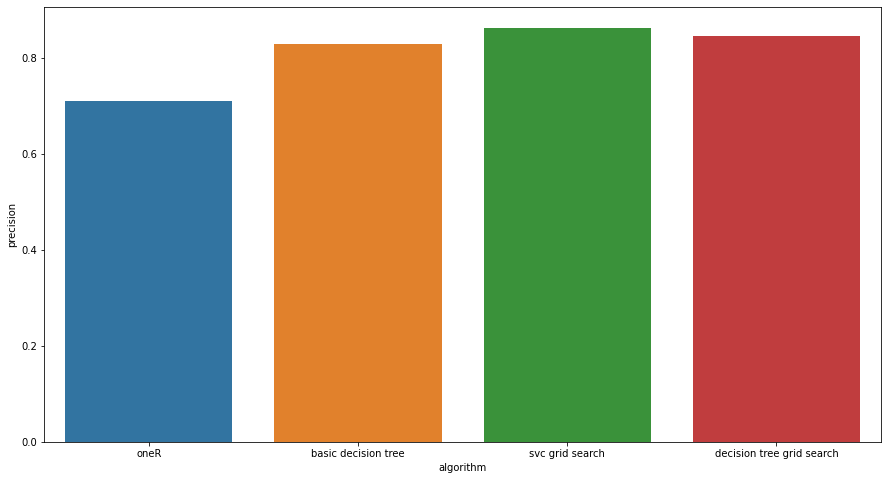

In [79]:
plt.figure(figsize=(15,8))
sns.barplot(data=algorithm_accuracy, x=algorithm_accuracy.algorithm, y=algorithm_accuracy.precision)

In [80]:
algorithm_accuracy[['algorithm', 'precision', 'hyperparameters']].sort_values(by='precision', ascending=False)

,algorithm,precision,hyperparameters
2,svc grid search,0.863140,"C:10,kernel:rbf"
3,decision tree grid search,0.845528,"criterion:entropy,max_depth:11,max_leaf_nodes:..."
1,basic decision tree,0.828890,NaN
0,oneR,0.709647,NaN


Môžeme vidieť, že klasifikačný algoritmus SVC s hyperparametrami optimalizovanými cez grid search dosiahol na testovacej sade dát najvyššiu precision. Nasledoval rozhodovací strom s hyperparametrami optimalizovanými cez grid search, rozhodovací strom bez hyperparametrov a nakoniec najnižšiu precision dosiahol nami implementovaný one-R algoritmus.

<AxesSubplot:xlabel='algorithm', ylabel='recall'>

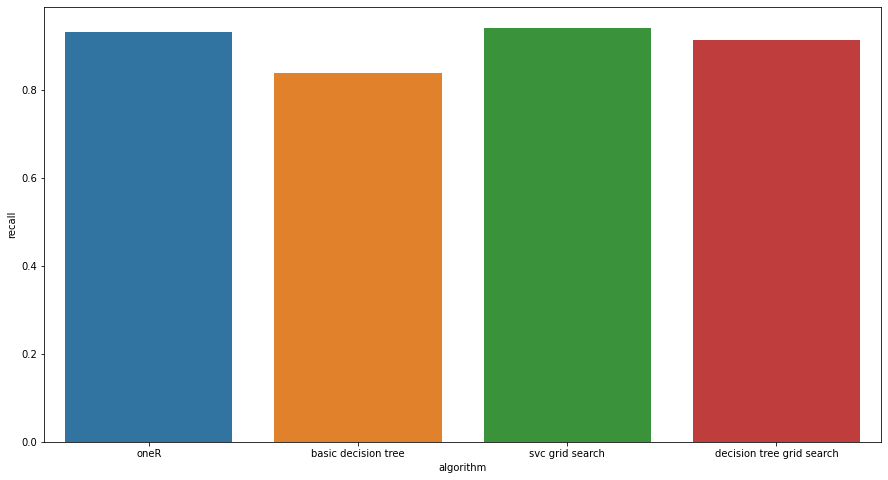

In [81]:
plt.figure(figsize=(15,8))
sns.barplot(data=algorithm_accuracy, x=algorithm_accuracy.algorithm, y=algorithm_accuracy.recall)

In [82]:
algorithm_accuracy[['algorithm', 'recall', 'hyperparameters']].sort_values(by='recall', ascending=False)

,algorithm,recall,hyperparameters
2,svc grid search,0.942247,"C:10,kernel:rbf"
0,oneR,0.932831,NaN
3,decision tree grid search,0.913999,"criterion:entropy,max_depth:11,max_leaf_nodes:..."
1,basic decision tree,0.839297,NaN


Môžeme vidieť, že klasifikačný algoritmus SVC s hyperparametrami optimalizovanými cez grid search dosiahol na testovacej sade dát najvyšší recall. Nasledoval nami implementovaný one-R algoritmus, rozhodovací strom s hyperparametrami optimalizovanými cez grid search a najnižší recall dosiahol rozhodovací strom bez hyperparametrov.

## 4. Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu 

Najskôr vytvoríme ucelený dataframe z tabuliek profiles a labor a upravíme atribúty tak, ako v druhej fáze, teda odstránime duplikáty, zjednotíme hodnoty, odstránime nepotrebné stĺpce a zakódujeme nečíselné hodnoty.

In [84]:
dfp.drop('Unnamed: 0', axis=1, inplace=True)
dfp['race'] = dfp['race'].str.replace('white','White')
dfp['race'] = dfp['race'].str.replace('black','Black')
dfp['race'] = dfp['race'].str.replace('blsck','Black')
dfp['birthdate'] = (pd.to_datetime(dfp.birthdate)).dt.year


dfl.drop('Unnamed: 0', axis=1, inplace=True)
dfl = dfl.drop_duplicates()
dfl['smoker'] = dfl['smoker'].str.replace('N','no')
dfl['smoker'] = dfl['smoker'].str.replace('Y','yes')

In [85]:
df = pd.merge(dfp, dfl, how="left", on=["ssn"])

df.drop('name_x', axis=1, inplace=True)
df.drop('name_y', axis=1, inplace=True)
df.drop('job', axis=1, inplace=True)
df.drop('address', axis=1, inplace=True)
df.drop('residence', axis=1, inplace=True)
df.drop('relationship', axis=1, inplace=True)
df.drop('blood_group', axis=1, inplace=True)
df.drop('race', axis=1, inplace=True)
df.drop('ssn', axis=1, inplace=True)

# create an object of the OneHotEncoder
ce_OHE = ce.OneHotEncoder(cols=['sex', 'smoker'])

# fit and transform and you will get the encoded data
df = ce_OHE.fit_transform(df)
df = df.rename(columns={"sex_1": "sex_f", "sex_2": "sex_m", "smoker_1": "smoker_no", "smoker_2": "smoker_yes"})
df.head()

,birthdate,sex_f,sex_m,leukocyty,smoker_no,smoker_yes,hemoglobin,trombocyty,indicator,alt,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
0,1925,1,0,6.35996,1,0,7.05602,5.71857,1.0,16.37812,51.36819,43.29070,70.74271,7.45522,6.08021,5.85295,39.27380,4.42627
1,1925,1,0,6.11726,0,1,6.47482,6.54765,1.0,16.43658,29.84194,28.92169,82.95045,4.53835,6.37624,7.37613,46.09380,4.43045
2,1925,1,0,6.65582,1,0,9.75669,8.89793,1.0,15.94319,122.71392,46.08027,23.47025,4.54148,7.61836,6.73630,54.74172,5.24299
3,1925,1,0,6.77521,1,0,6.89806,6.73572,1.0,15.15328,81.49556,32.56414,80.44580,4.35633,4.75844,7.14693,57.04543,4.27777
4,1912,0,1,5.99290,0,1,8.93612,5.38672,1.0,11.70433,65.37642,35.27976,22.40511,6.03565,6.26289,4.54114,71.58272,4.89556


In [122]:
from sklearn.model_selection import train_test_split

In [87]:
nan_columns = df.columns[df.isna().any()].tolist()
nan_columns

['leukocyty',
 'hemoglobin',
 'trombocyty',
 'alt',
 'ast',
 'alp',
 'hematokrit',
 'hbver',
 'etytr',
 'er-cv',
 'erytrocyty']

In [101]:
# imputer
imp_knn = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
def replace_nan(df):
    imp_knn.fit(df[nan_columns])
    df[nan_columns] = imp_knn.transform(df[nan_columns])
    return df

In [89]:
##funkcia na detekciu outlierov
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]

In [90]:
##funkcia na detekciu outlierov, vrati oddelene zoznamy indexov prilis vysokych a prilis nizkych hodnot
def identify_outliers_low_up(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a < lower)].index.values.astype(int), a[(a > upper)].index.values.astype(int)

In [91]:
##nahradenie hodnot outlierov hodnotami 5. a 95. percentilom rozlozenia
def replace_outliers(df):
    for col in nan_columns + ['birthdate', 'weight']:
        low, up = identify_outliers_low_up(df[col])
        df.loc[low, col] = df[col].quantile(0.05)
        df.loc[up, col] = df[col].quantile(0.95)
    return df

In [92]:
class Transformer(TransformerMixin):
    def __init__(self, transform_columns, passthrough_columns):
        self.transformer = ColumnTransformer(transformers=[("PT", PowerTransformer(method='yeo-johnson', standardize=True), transform_columns)], remainder='passthrough')
        self.columns = transform_columns + passthrough_columns
    
    def fit(self, X_pipe, y=None, **fit_params):
        self.transformer.fit(X_pipe)
        return self
        
    def transform(self, X_pipe, **transform_params):
        X_pipe = pd.DataFrame(self.transformer.transform(X_pipe), columns=self.columns)
        return X_pipe

In [93]:
class Scaler(TransformerMixin):
    def __init__(self):
        self.scaler = MinMaxScaler()
    
    def fit(self, X_pipe, y=None, **fit_params):
        self.scaler.fit(X_pipe)
        return self
        
    def transform(self, X_pipe, **transform_params):
        return pd.DataFrame(self.scaler.transform(X_pipe), columns=X_pipe.columns)

In [98]:
class FeatureSelector(TransformerMixin):
    def __init__(self):
        self.selector = SelectKBest(mutual_info_regression, k=5)
        
    def fit(self, X_pipe, y_pipe, **fit_params):
        self.y_ = y_pipe
        return self
        
    def transform(self, X_pipe, **transform_params):
        self.selector.fit(X_pipe, self.y_)
        scores = pd.Series((0 for col in X_train.columns), index=X_pipe.columns, dtype=float)
        mi_values = pd.Series(self.selector.scores_, index=X_pipe.columns)
        for col in mi_values.index:
            scores[col] = mi_values[col]
        scores = scores.sort_values(ascending=False)
        # zmenime poradie stlpcov X_pipe podla scores Series, aby mal rovnake poradie stlpcov
        X_pipe = X_pipe[scores.index]
        return X_pipe

In [154]:
transform_columns = ['leukocyty', 'hemoglobin', 'trombocyty', 'alt', 'ast', 'alp', 'hematokrit', 'hbver', 'etytr', 'er-cv', 'erytrocyty', 'weight']
passthrough_columns = ['birthdate', 'sex_f', 'sex_m', 'smoker_no', 'smoker_yes']

In [119]:
strategies = pd.DataFrame(columns=['strategy_no', 'accuracy'])

Nami zvolené stratégie a ich úspešnosť budeme testovať na klasifikátore Decision Tree s hyperparametrami nájdenými pomocou Grid Search.

### Stratégia 1

Ako prvú stratégiu sme zvolili tú, ktorú už máme vypracovanú z predošlej fázy. Na dáta aplikujeme nahradenie chýbajúcich hodnôt pomocou kNN Imputer, outlierov nahradíme hraničnými hodnotami, aplikujeme PowerTransformer na transformáciu dát, MinMaxScaler na scaling dát a SelectkBest feature selector na výber 5 najlepších atribútov.

In [120]:
strategies = strategies.append({'strategy_no':1, 'accuracy':algorithm_accuracy[algorithm_accuracy['algorithm']=='decision tree grid search'].accuracy.values[0]}, ignore_index=True)

In [121]:
strategies

,strategy_no,accuracy
0,1.0,0.8375


### Stratégia 2

V druhej stratégii odstránime z dát chýbajúce hodnoty a rovnako odstránime aj outlierov. Na dáta následne aplikujeme PowerTransformer, MinMaxScaler a nájdeme 5 najlepších atribútov nájdených pomocou SelectKBest algoritmu.

In [157]:
df2 = deepcopy(df)
len(df2)

9918

In [158]:
len(df2) - len(df2.dropna())

324

In [159]:
df2 = df2.dropna()
len(df2)

9594

In [160]:
outliers = []
d = {}
for col in nan_columns + ['birthdate', 'weight']:
    x = identify_outliers(df2[col]).index.values.astype(int)
    d[col] = x
    for element in x:
        if element not in outliers:
            outliers.append(element)

print(len(outliers))
df2.drop(outliers, inplace=True)

703


In [161]:
len(df2)

8891

In [162]:
ppl = Pipeline([
    ('power-transformer', Transformer(transform_columns, passthrough_columns)),
    ('minmax-scaler', Scaler()),
    ('feature-selector', FeatureSelector())
])

In [163]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df2.loc[:, df2.columns != 'indicator'], df2['indicator'])

In [164]:
ppl_transformed_train2 = ppl.fit_transform(X_train2, y_train2)
ppl_transformed_test2 = ppl.fit_transform(X_test2, y_test2)

In [165]:
selected_columns = ppl_transformed_train2.columns[0:5]
ppl_transformed_train2 = ppl_transformed_train2[selected_columns]
ppl_transformed_test2 = ppl_transformed_test2[selected_columns]
ppl_transformed_train2.head()

,hematokrit,hemoglobin,smoker_no,alp,er-cv
0,0.640848,0.310435,0.0,0.785565,0.433348
1,0.911897,0.233258,1.0,0.431027,0.653349
2,0.497785,0.470530,0.0,0.802778,0.508253
3,0.383338,0.183132,1.0,0.260714,0.657727
4,0.290792,0.562204,1.0,0.482892,0.825974


In [166]:
grid_strategy2 = GridSearchCV(decision_tree, param_grid=params, cv=5, verbose=1)
grid_strategy2.fit(ppl_transformed_train2, y_train2)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [5, 8, 11, 14],
                         'max_leaf_nodes': [337, 340, 343, 346],
                         'min_samples_leaf': [5, 8, 11, 14],
                         'min_samples_split': [5, 8, 11, 14]},
             verbose=1)

In [167]:
ypred_strategy2 = grid_strategy2.best_estimator_.predict(ppl_transformed_test2)

In [168]:
acc = metrics.accuracy_score(y_test2, ypred_strategy2)
print("Accuracy of strategy 2:", acc * 100, '%')

Accuracy : 73.45928924876294 %


In [186]:
strategies = strategies.append({'strategy_no':2, 'accuracy':acc}, ignore_index=True)

In [187]:
strategies

,strategy_no,accuracy
0,1.0,0.837500
1,2.0,0.835887


### Stratégia 3

V tretej stratégii nahradíme chýbajúce hodnoty pomocou kNN Imputera, nahradíme outlierov hraničnými hodnotami, následne aplikujeme PowerTransformer a použijeme 5 najlepších atribútov nájdených pomocou SelectkBestfeature selectora vo fáze 2. V tejto stratégii teda vynecháme scaleovanie dát.

In [174]:
df3 = deepcopy(df)

Chýbajúce hodnoty nahradíme pomocou kNN imputera definovaného vyššie.

In [176]:
df3 = replace_nan(df3)

Nahradíme outlierov v stĺpcoch hraničnými hodnotami stĺpca pomocou vyššie definovaných funkcií. Konkrétne outlierov za maximom nahradíme hodnotou 95. percentilu a outlierov za minimom nahradíme hodnotou 5. percentilu.

In [178]:
df3 = replace_outliers(df3)

In [179]:
ppl = Pipeline([
    ('power-transformer', Transformer(transform_columns, passthrough_columns)),
#     ('minmax-scaler', Scaler()),
    ('feature-selector', FeatureSelector())
])

In [180]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(df3.loc[:, df3.columns != 'indicator'], df3['indicator'])

In [181]:
ppl_transformed_train3 = ppl.fit_transform(X_train3, y_train3)
ppl_transformed_test3 = ppl.fit_transform(X_test3, y_test3)

In [182]:
selected_columns = ppl_transformed_train3.columns[0:5]
ppl_transformed_train3 = ppl_transformed_train3[selected_columns]
ppl_transformed_test3 = ppl_transformed_test3[selected_columns]
ppl_transformed_train3.head()

,hemoglobin,hematokrit,smoker_no,hbver,alt
0,-0.878107,1.305470,1.0,-0.379114,0.295038
1,1.024015,0.286410,0.0,0.397735,-0.736948
2,0.277324,0.704653,0.0,0.176120,-0.402951
3,-1.748324,-0.059195,0.0,0.935229,-0.933751
4,-0.920141,-0.343071,0.0,-0.198647,-1.046830


In [183]:
grid_strategy3 = GridSearchCV(decision_tree, param_grid=params, cv=5, verbose=1)
grid_strategy3.fit(ppl_transformed_train3, y_train3)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [5, 8, 11, 14],
                         'max_leaf_nodes': [337, 340, 343, 346],
                         'min_samples_leaf': [5, 8, 11, 14],
                         'min_samples_split': [5, 8, 11, 14]},
             verbose=1)

In [184]:
ypred_strategy3 = grid_strategy3.best_estimator_.predict(ppl_transformed_test3)

In [185]:
acc = metrics.accuracy_score(y_test3, ypred_strategy3)
print("Accuracy of strategy 3:", acc * 100, '%')

Accuracy of strategy 3: 83.58870967741936 %


In [188]:
strategies = strategies.append({'strategy_no':3, 'accuracy':acc}, ignore_index=True)

### Stratégia 4

V štvrtej stratégii nahradíme chýbajúce hodnoty pomocou kNN Imputera, nahradíme outlierov hraničnými hodnotami, následne aplikujeme MinMaxScaler a použijeme 5 najlepších atribútov nájdených pomocou SelectkBestfeature selectora. V tejto stratégii teda vynecháme tranformáciu dát.

In [189]:
df4 = deepcopy(df)

In [190]:
df4 = replace_nan(df4)

In [191]:
df4 = replace_outliers(df4)

In [192]:
ppl = Pipeline([
#     ('power-transformer', Transformer(transform_columns, passthrough_columns)),
    ('minmax-scaler', Scaler()),
    ('feature-selector', FeatureSelector())
])

In [193]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(df4.loc[:, df4.columns != 'indicator'], df4['indicator'])

In [194]:
ppl_transformed_train4 = ppl.fit_transform(X_train4, y_train4)
ppl_transformed_test4 = ppl.fit_transform(X_test4, y_test4)

In [195]:
selected_columns = ppl_transformed_train4.columns[0:5]
ppl_transformed_train4 = ppl_transformed_train4[selected_columns]
ppl_transformed_test4 = ppl_transformed_test4[selected_columns]
ppl_transformed_train4.head()

,hemoglobin,hematokrit,birthdate,sex_f,ast
0,0.432654,0.377312,0.741379,0.0,0.691952
1,0.679609,0.697310,0.181034,1.0,0.530198
2,0.421720,0.729977,0.025862,0.0,0.776382
3,0.584137,0.745408,0.094828,1.0,0.487074
4,0.712348,0.729645,0.068966,1.0,0.415244


In [196]:
grid_strategy4 = GridSearchCV(decision_tree, param_grid=params, cv=5, verbose=1)
grid_strategy4.fit(ppl_transformed_train4, y_train4)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [5, 8, 11, 14],
                         'max_leaf_nodes': [337, 340, 343, 346],
                         'min_samples_leaf': [5, 8, 11, 14],
                         'min_samples_split': [5, 8, 11, 14]},
             verbose=1)

In [197]:
ypred_strategy4 = grid_strategy4.best_estimator_.predict(ppl_transformed_test4)

In [198]:
acc = metrics.accuracy_score(y_test4, ypred_strategy4)
print("Accuracy of strategy 4:", acc * 100, '%')

Accuracy of strategy 4: 73.79032258064517 %


In [199]:
strategies = strategies.append({'strategy_no':4, 'accuracy':acc}, ignore_index=True)

### Porovnanie stratégií

In [200]:
strategies

,strategy_no,accuracy
0,1.0,0.837500
1,2.0,0.835887
2,3.0,0.835887
3,4.0,0.737903


<AxesSubplot:xlabel='strategy_no', ylabel='accuracy'>

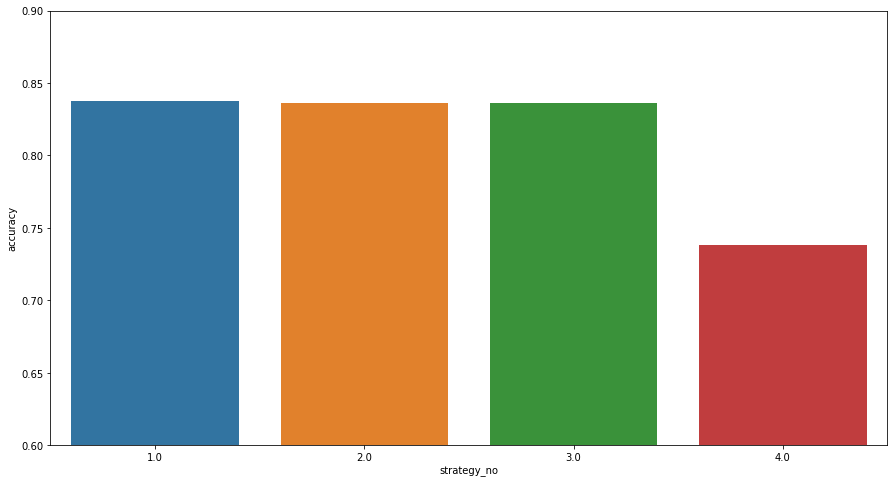

In [203]:
plt.figure(figsize=(15,8))
plt.ylim(0.6, 0.9)
sns.barplot(data=strategies, x=strategies.strategy_no, y=strategies.accuracy)

In [211]:
strategies[['strategy_no', 'accuracy']].sort_values(by='accuracy', ascending=False).loc[0]

strategy_no    1.0000
accuracy       0.8375
Name: 0, dtype: float64

Po porovnaní stratégií sme zistili, že prvá stratégia dosahuje najvyššiu úspešnosť. Teda najlepším prístupom je nahradenie NaN values pomocou kNN imputera, nahradenie outlierov hraničnými hodnotami stĺpcov, aplikovanie scaleovania dát cez MinMaxScaler, aplikovanie transformácie dát cez PowerTransformer a výber atribútov pomocou SelectKBest algoritmu.

Najmenej úspešná bola stratégia číslo 2, teda stratégia v ktorej sme v predspracovaní dát odstránili NaN values, odstránili outlierov a následne na takto očistené dáta aplikovali MinMaxScaler scaling a PowerTransformer transformáciu.

Porovnanie rôznych algoritmov klasifikácie máme v predošlej sekcii tohto dokumentu - porovnávali sme náš One-R klasifikátor, SVC s hyperparametrami podľa Grid Search, Decision Tree bez hyperparametrov a Decision Tree s použitím hyperparametrov nájdených pomocou Grid Search. Najúspešnejší je SVC s hyperparametrami a za ním Decision Tree s hyperparametrami.